# Exercise 9 - SVMs and Polynomial Kernels (30 Points + 4 Bonus Points)

In this exercise you will implement a Support Vector Machine and compare them with logistic regression.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- christoph.staudt@uni-jena.de

### Submission

- Deadline of submission:
        24.06.2022 14:00
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=28746)

# The Dataset

We are using the [circle dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) from last time again. This time I included the transormation for you already, we will need `X` without the additional column of ones later, we add the ones to `X_poly`.


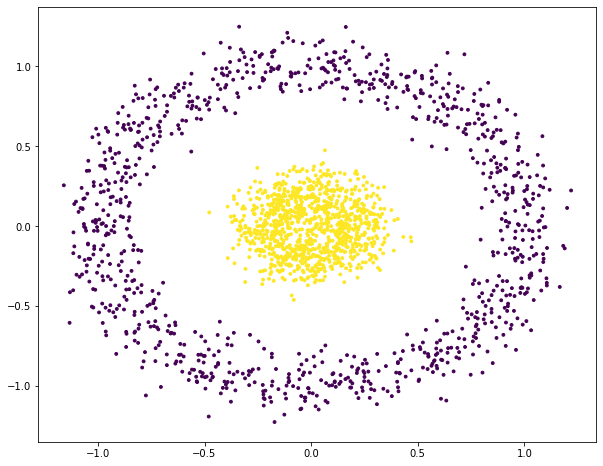

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split

X, Y = datasets.make_circles(n_samples=2000, factor=0.2, noise=0.1, random_state=21)
Y = Y * 2 - 1
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=21
)
X_poly = np.insert(X, 0, 1.0, axis=1)
X_train_poly = np.insert(X_train, 0, 1.0, axis=1)
X_test_poly = np.insert(X_test, 0, 1.0, axis=1)
plt.scatter(X[:, 0], X[:, 1], c=Y, s=8)


I copied over the code from the last exercise so we can use it to compare SVMs with logistic regression.


In [65]:
def sigmoid(X):
    # TODO: implement sigmoid function
    return 1 / (1 + np.exp(-X))

def acc(Y, Y_hat):
    # TODO: implement accuracy
    return np.mean(Y == Y_hat)

def predict(X, theta):
    return np.sign(X @ theta)

def get_probs(X, theta):
    return sigmoid((X @ theta))

def plot_dec_boundary(X, Y, get_probs, boundary_level = 0.5):
    # TODO: plot data and decision boundary

    # make these smaller to increase the resolution
    dx, dy = 0.05, 0.05
    levels = np.arange(0.4, 0.6, 2e-3)
    plt.rcParams["figure.figsize"] = (10, 8)
    # generate grids + probs
    x1, x2 = np.mgrid[
        slice(np.min(X[:, -2]), np.max(X[:, -2]) + dy, dy),
        slice(np.min(X[:, -1]), np.max(X[:, -1]) + dx, dx),
    ]
    points = np.stack([np.ones(np.prod(x1.shape)), x1.flatten(), x2.flatten()]).T
    if X.shape[1] == 2:
        points = points[:,1:]
    probs = get_probs(points).reshape(x1.shape)
    max_prob = np.max(probs)
    min_prob = np.min(probs)
    dist = max(abs(max_prob - boundary_level), abs(min_prob - boundary_level))
    step = dist / 100
    levels = np.arange(boundary_level - dist - step, boundary_level + dist + step, step)
    # plot points + heatmap
    cmap = plt.get_cmap("seismic")
    plt.contourf(
        x1,
        x2,
        probs,
        cmap=cmap,
        levels=levels,
        alpha=0.4,
    )
    plt.colorbar()
    plt.contour(x1, x2, probs, levels=[boundary_level], colors="black", linewidths=2)
    plt.scatter(X[:, -2], X[:, -1], c=Y, cmap="bwr",s=8)

def fAndG(X, w, y):
    # TODO: Paste code from matrix calculus
    assert isinstance(X, np.ndarray)
    dim = X.shape
    assert len(dim) == 2
    X_rows = dim[0]
    X_cols = dim[1]
    assert isinstance(w, np.ndarray)
    dim = w.shape
    assert len(dim) == 1
    w_rows = dim[0]
    assert isinstance(y, np.ndarray)
    dim = y.shape
    assert len(dim) == 1
    y_rows = dim[0]
    assert y_rows == X_rows
    assert X_cols == w_rows

    t_0 = np.exp(-(y * (X).dot(w)))
    t_1 = np.ones(y_rows) + t_0
    functionValue = np.sum(np.log(t_1))
    gradient = -(X.T).dot(((t_0 * y) / t_1))

    return functionValue, gradient


def fit(X, Y, fAndG, lr=2e-4, max_it=15000, eps=1e-8):
    # Init random theta
    theta = np.random.rand(X.shape[1])  # -0.5
    current_loss, grad = fAndG(X, theta, Y)
    accuracies = []
    losses = []
    for it in range(max_it):
        # update
        theta = theta - lr * grad

        # determine accuracy
        Y_hat = predict(X, theta)
        accuracy = acc(Y, Y_hat)

        # Save old loss
        old_loss = current_loss
        # determine new loss and next gradient
        current_loss, grad = fAndG(X, theta, Y)

        # Save values for plotting
        accuracies.append(accuracy)
        losses.append(current_loss)

        # Stop if change in loss got small
        if abs(current_loss - old_loss) < eps:
            break
    print(f"Iterations: {it}")
    return theta, accuracies, losses


def kernel(X1, X2, d):
    # TODO: Implement polynomial kernel
    return (X1 @ X2.T + 1) ** d

def predict_poly(K, a):
    # TODO: implement predict
    return np.sign(K @ a)

def get_probs_poly(X_train,X,a,d):
    # TODO: Calculate probabilities
    K = kernel(X,X_train,d)
    return sigmoid(K @ a)

def fAndG_poly(K, a, c, y):
    # TODO: copy & paste function body from downloaded code
    assert isinstance(K, np.ndarray)
    dim = K.shape
    assert len(dim) == 2
    K_rows = dim[0]
    K_cols = dim[1]
    assert isinstance(a, np.ndarray)
    dim = a.shape
    assert len(dim) == 1
    a_rows = dim[0]
    if isinstance(c, np.ndarray):
        dim = c.shape
        assert dim == (1,)
    assert isinstance(y, np.ndarray)
    dim = y.shape
    assert len(dim) == 1
    y_rows = dim[0]
    assert a_rows == K_rows == y_rows
    assert K_cols == a_rows == K_rows
    assert K_cols == a_rows == K_rows == y_rows

    t_0 = (K).dot(a)
    t_1 = np.exp(-(y * t_0))
    t_2 = np.ones(a_rows) + t_1
    functionValue = np.sum(np.log(t_2)) + (c * (a).dot(t_0))
    gradient = ((2 * c) * t_0) - (K).dot(((t_1 * y) / t_2))

    return functionValue, gradient

def fit_poly(X, Y, d, fAndG, c=1e-2, lr=1e-6, max_it=10000,eps=1e-2):
    # Init random theta
    a = np.random.rand(X.shape[0]) -0.5
    K = kernel(X,X,d)
    current_loss,grad = fAndG(K,a,c,Y)
    accuracies = []
    losses = []    
    for it in range(max_it):        
        # update
        a = a - lr*grad
        
        # determine accuracy
        Y_hat = predict_poly(K,a)
        accuracy = acc(Y, Y_hat)

        # Save old loss
        old_loss = current_loss
        # determine new loss and next gradient        
        current_loss,grad = fAndG(K,a,c,Y)

        # Save values for plotting
        accuracies.append(accuracy)
        losses.append(current_loss)
        
        # Stop if change in loss got small
        if abs(current_loss-old_loss)<eps:
            break
    print(f'Iterations: {it}')
    return a,accuracies,losses

Results without Kernel:

Iterations: 473
[ 0.03878007 -0.03308304 -0.09337417]
Accuracy: 0.6986666666666667, Loss: 1038.9550668696784
Test accuracy: 0.632


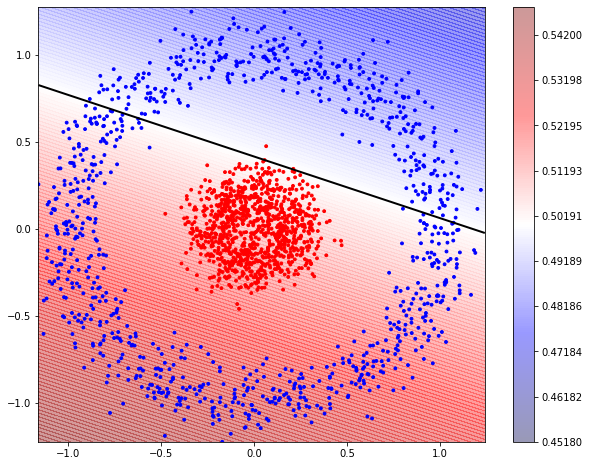

In [66]:
theta, accuracies, losses = fit(X_train_poly, Y_train, fAndG)
print(theta)
print(f'Accuracy: {accuracies[-1]}, Loss: {losses[-1]}')
print(f'Test accuracy: {acc(predict(X_test_poly,theta), Y_test)}')

plot_dec_boundary(X_poly,Y,lambda X: get_probs(X,theta))

Results with Kernel:

Iterations: 1666
Accuracy: 1.0, Loss: 28.63484357869218
Test accuracy: 1.0


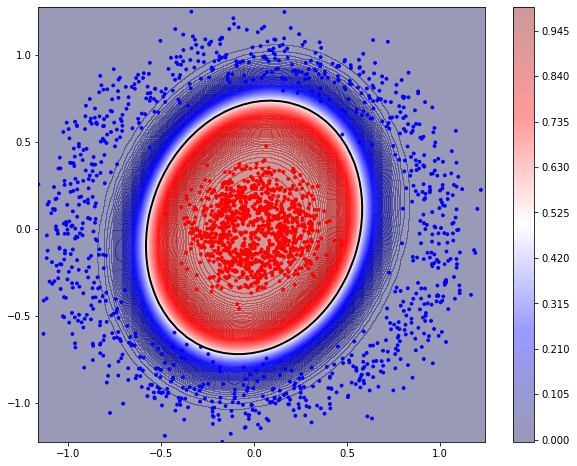

In [67]:
d = 2
a,accuracies,losses = fit_poly(X_train_poly,Y_train,d,fAndG_poly)
print(f'Accuracy: {accuracies[-1]}, Loss: {losses[-1]}')
print(f'Test accuracy: {acc(predict_poly(kernel(X_test_poly,X_train_poly,d),a), Y_test)}')
plot_dec_boundary(X_poly,Y,lambda X: get_probs_poly(X_train_poly,X,a,d))


# SVM

The standard soft margin support vector machine is defined by the loss function:
\begin{align*}
L(X,Y,\theta) = \cfrac{1}{2}||\theta||^2+C\sum_{i=1}^m\max\{1-y^{(i)}(\theta^Tx^{(i)}), 0\}.
\end{align*}


As always the goal is to find a parameter vector $\theta$ and we can use the fact, that $\theta$ is a linear combination of the training datapoints (representer theorem, like in the last exercise)
\begin{align*}
\theta = \sum_{i=1}^m w_i x_{\text{train}}^{(i)} = w^T X_{\text{train}}
\end{align*}

to rewrite the objective function as:
\begin{align*}
L(X,Y,w) = \cfrac{1}{2}w^TX_{\text{train}}X_{\text{train}}^Tw+C\sum_{i=1}^m\max\{1-y^{(i)}(w^TX_{\text{train}}x^{(i)}+b), 0\}\,.
\end{align*}

Note that the labels $y^{(i)}$ have to be binary in $\{-1,1\}$.

This loss function relies on the dot product as a measure of similarity between two datapoints.
For two matrices $X_1\in\mathbb{R}^{m_1\times d}, X_2\in\mathbb{R}^{m_2\times d}$, we call the matrix of pairwise similarity $c = X_1X_2^T\in\mathbb{R}^{m_\times m}$

This leads to:
$$
L(X,Y,w) = \cfrac{1}{2}w^T\operatorname{Sim}\left(X_{\text{train}}, X_{\text{train}}\right)w+C\sum_{i=1}^m\max\left\{1-y^{(i)}\left(w^T\operatorname{Sim}\left(X_{\text{train}}, x^{(i)}\right)+b\right), 0\right\}\,.
$$


### Task 1 (2 Points)

Implement the pairwise similarity function for dot products. We will use this similarity function everytime we have a dot product between two datapoints.

In [68]:
def sim(X1, X2):
    # TODO: Implement similarity function as dot products between two sets of vectors
    return X1 @ X2.T

Lets have a closer look at the second part of our cost (loss) function $L$:

The innermost component 

$$
\operatorname{Dec}(x):= w^TX_{\text{train}}x+b = w^T \operatorname{Sim}(X_{\text{train}},x)+b
$$

produces a *decision* of the SVM that can be used for a *prediction*

$$
\hat{y}=\operatorname{Pred}(x) := \begin{cases}
1\text{, if }\operatorname{Dec}(x)\geq 0\\
-1\text{, else}
\end{cases}
$$

for the label $\hat{y}$ of the sample $x$.

Next, we multiply this decision with the true label. 
$$
\operatorname{Marg}(x):=y\operatorname{Dec}(x) %= y(w^TX_{\text{train}}x+b)
$$

This term is called *margin*.

Recall, that our true labels are $\in\{-1,1\}$. Therefore
$$
\max\{1-\operatorname{Marg}(x), 0\} = \begin{cases}
0\text{, if }\operatorname{sign}(\operatorname{Dec}(x))=\operatorname{sign}(y)\text{ and }|\operatorname{Dec}(x)|\geq 1\\
\in(0,1]\text{, if }\operatorname{sign}(\operatorname{Dec}(x))=\operatorname{sign}(y)\text{ and }|\operatorname{Dec}(x)|< 1\\
\in(1,\infty)\text{, if }\operatorname{sign}(\operatorname{Dec}(x))\neq \operatorname{sign}(y)
\end{cases}
$$

gives us a measure on the error we made with a decision.  The term

\begin{align*}
\xi_i := 1-\operatorname{Marg}\left(x^{(i)}\right)
\end{align*}
is called *slack*. This means our objective function aims to minimize the slack for all samples $x^{(i)} \in X_\text{train}$.

Note, that we use a corpus of features $X$ (our trainingdata) to calculate the decision (and prediction) for other features.

### Task 2 (6 Points)

Implement the cost function and the functions for decision, prediction, margin and slack. 

Implement these functions, so that everything is calculated for *multiple* new feature vectors $x$ at once. They should use a similarity matrix `sim` as defined above.

In [69]:
def decision(sim, w, b):
    # TODO: Implement decision function
    return w.T @ sim + b

def predict_svm(sim, w, b):
    # TODO: Implement prediction function
    return np.sign(decision(sim, w, b))

def margin(sim, Y, w, b):
    # TODO: Implement margin function
    return Y * decision(sim, w, b)

def slack(sim, Y, w, b):
    # TODO: Implement slack
    return 1 - margin(sim, Y, w, b)

def cost(sim, Y, w, b, C):
    # TODO: Implement cost function
    return 0.5 * w.T @ sim @ w + C * sum([np.maximum(slack(sim[i], Y[i], w, b), 0) for i in range(len(Y))])

Our goal is to minimize the cost function. We will do so by using gradient descend on the two optimizable parameters $w$ and $b$.

\begin{align}
\frac{\partial L}{\partial w}&=X_{\text{train}}X_{\text{train}}^Tw-C\sum_{i=1, \xi_i\geq 0}^m y^{(i)}X_{\text{train}}x^{(i)} = \operatorname{Sim}(X_\text{train},X_\text{train})w-C\sum_{i=1, \xi_i\geq 0}^m y^{(i)}\operatorname{Sim}\left(X_{\text{train}},x^{(i)}\right)\\
\frac{\partial L}{\partial b}&=-C\sum_{i=1, \xi_i\geq 0}^m y^{(i)}
\end{align}

To recall gradient descend, have a look at the code above from the last exercise. Also note that the gradients depend on the slack.

### Task 3 (5 Points)
Implement functions that calculate the gradients with respect to $w$ and $b$. Again, use a precalculated `sim` matrix for computing the dot products between datapoints.

In [85]:
def grad_b(sim, Y_train, w, b, C):
    # TODO: Implement gradient wrt. b
    indices = np.array([slack(sim[i], Y_train[i], w, b) for i in range(len(Y_train))]) >= 0
    return -C * np.sum(Y_train[indices], axis=0)

def grad_w(sim, Y_train, w, b, C):
    # TODO: Implement gradient wrt. w
    indices = np.array([slack(sim[i], Y_train[i], w, b) for i in range(len(Y_train))]) >= 0
    # print(np.sum(indices))
    return sim @ w - C * Y_train[indices] @ sim[indices]


### Task 4 (6 Points)

Implement a function `fit_svm`, that uses gradient descend to get values for $w$ and $b$.
In each iteration (epoch), `fit_svm` should 
- update $w$ and $b$ with gradient descend
- calculate the current loss
- calculate the current accuracy on train- and testdata
- check if the current loss changed by more than a threshold `eps`; if not stop the process

The output of `fit_svm` should be the final $w$, $b$ and the loss and accuracy statistics. Morevoer, `fit_svm` should accept a similarity **function** `sim`. 

In [86]:
def fit_svm(
    X_train, X_test, Y_train, Y_test, sim, C=10, lr=1e-10, epochs=50, eps=1e-3
):
    # TODO: Initialize w and b
    w = np.zeros(len(X_train))
    b = 0

    train_losses = []
    train_accs = []
    test_accs = []
    # TODO: Implement gradient descent
    
    sim_train = sim(X_train, X_train)
    sim_test = sim(X_train, X_test)
    current_loss = cost(sim_train, Y_train, w, b, C)
    for it in range(epochs):        
        # update
        w -= lr * grad_w(sim_train, Y_train, w, b, C)
        b -= lr * grad_b(sim_train, Y_train, w, b, C)
        
        # determine accuracy
        train_prediction = predict_svm(sim_train, w, b)
        train_accs.append(acc(Y_train, train_prediction))
        
        test_prediction = predict_svm(sim_test, w, b)
        test_accs.append(acc(Y_test, test_prediction))

        # Save old loss
        old_loss = current_loss
        # calculate new loss
        current_loss = cost(sim_train, Y_train, w, b, C)
        train_losses.append(current_loss)
        
        # Stop if change in loss got small
        if abs(current_loss - old_loss) < eps:
            break
    
    stats = {"loss": train_losses, "accs": {"test": test_accs, "train": train_accs}}
    print(f"Epochs: {it + 1}")
    return w, b, stats


### Task 5 (2 Points)
Now use your `fit_svm` function to get `w` and `b`. You should tune the hyperparameters to get good results 

In [110]:
# TODO: Use fit function
w, b, stats = fit_svm(X_train, X_test, Y_train, Y_test, sim, lr=1e-5)

[-33.01395018  61.13134132  23.25344551 ...  25.46501381 182.55789922
 -28.42492017]
[-27.60025815  52.5032834   18.17152922 ...  24.36968058 148.45797501
 -23.730135  ]
[  269.69824095  -500.16243047  -189.26560012 ...  -209.72139107
 -1489.06864718   232.19098023]
[-467.71704112  890.04345465  307.64873962 ...  413.6705876  2514.84016528
 -402.12587442]
[  472.54588356  -928.70528465  -284.0455873  ...  -482.95959156
 -2452.92215441   405.56811702]
[-497.42728803  995.50355903  282.73906175 ...  547.87366181 2528.70908084
 -426.49206116]
[  491.84044397  -989.31466306  -275.02760361 ...  -552.73296812
 -2485.42254707   421.58176375]
[-500.7924428  1009.58426484  277.97713331 ...  567.78568525 2523.91177311
 -429.20051018]
[  496.58599766 -1000.57682242  -276.12141066 ...  -561.85314553
 -2504.2844642    425.60810079]
[-501.70685608 1012.20294624  277.78029833 ...  570.53265399 2526.20862948
 -429.96554095]
[  499.03565587 -1006.78038959  -276.33164524 ...  -567.42141539
 -2512.858000

### Task 6 (2 Points)

To plot the decision boundary, we will need a function that returns probabilities. We do not really have this, so we just take the value of the decision function and bound it to $[-1,1]$, i.e. values greater than $1$ are set to $1$ and values lower than $-1$ are set to $-1$. Make sure to allow the calculation of several probabilities at once.

In [111]:
def get_probs_svm(X,X_train,w,b,sim):
    # TODO: calculate value of decision function
    # TODO: Set all array values greater than 1 to 1 and all values smaller than -1 to -1
    return np.clip(decision(sim(X_train, X), w, b), -1, 1)

### Task 9 (2 Points)
Plot the accuracies and losses as well as the predictions on the dataset. Use [partial](https://www.geeksforgeeks.org/partial-functions-python/), to turn `get_probs_svm` into a partial function, that just takes the points `X` as parameter, so you can use `plot_dec_boundary`. 

[ 0.03878007 -0.03308304 -0.09337417]


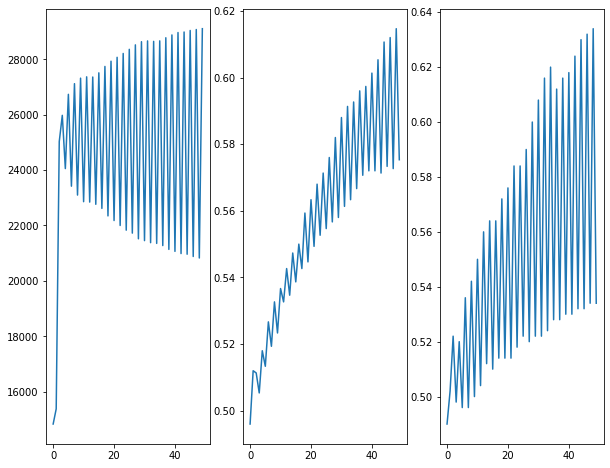

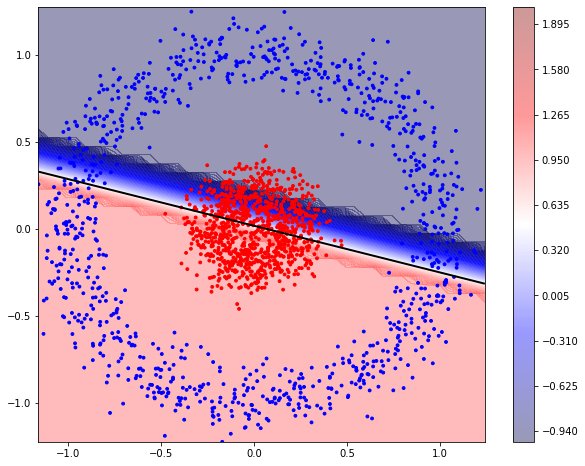

Test Accuracy: 0.534	Train Accuracy: 0.5753333333333334	 Loss: 28.63484357869218


In [112]:
import matplotlib.pyplot as plt
from functools import partial

# TODO: Plot accuracy and loss
fig, axs = plt.subplots(ncols=3)
print(theta)
axs[0].plot(stats["loss"])
axs[1].plot(stats["accs"]["train"])
axs[2].plot(stats["accs"]["test"])
plt.show()

# TODO: Plot decision boundary
get_probs_partial = partial(get_probs_svm, X_train=X_train, w=w, b=b, sim=sim)
plot_dec_boundary(X, Y, get_probs_partial)
plt.show()

test_acc = stats['accs']['test'][-1]
train_acc = stats['accs']['train'][-1]
print(f'Test Accuracy: {test_acc}\tTrain Accuracy: {train_acc}\t Loss: {losses[-1]}')

### Task 10 (5 Points)

All of our functions either depend on a similarity matrix or a function that returns one. So now we want to use a polynomial kernel as similarity function again. We can do this with minimal code adjustments. In fact, you just need to call `fit_svm` with a different function for the `sim` parameter. This similarity function should use the `kernel` method from the last exercise (its in the code I copied above) with a degree of 2. You can use `partial` on `kernel` to get such a function.

Fit the polynomial SVM (tune the hyperparameters if needed), and plot the accuracies and losses over the different epochs just as above. Finally visualize the result with `plot_dec_boundary`. Check out different values for `C` (e.g. 1, 10, 1000) and write down what you observe. Compare the results with logistic regression.

[ -36.19479475 2677.23562688  -67.02928755 ... 3692.27940471 3277.2997958
 -120.71933232]
[-7692.34341966 -7810.87594618 -7687.48257966 ... -7876.38083637
 -7874.31256845 -7684.71983229]
[ 7726.8255386  10558.9565597   7689.06005949 ... 11642.60295799
 11218.56215341  7634.35296363]
[-7717.74007478 -7847.76403771 -7713.74497309 ... -7916.26128353
 -7916.19784032 -7709.87181185]
[ 7701.91579639 10522.68642835  7663.29494057 ... 11603.37544406
 11177.35213666  7609.68502268]
[-7742.17148307 -7883.42685235 -7739.02150992 ... -7954.84712863
 -7956.74405739 -7734.06424032]
[ 7677.95429266 10487.62047124  7638.49844442 ... 11565.4201988
 11137.45846088  7585.95972921]
[-7765.67136457 -7917.90622998 -7763.34635842 ... -7992.18265101
 -7995.99625659 -7757.33063018]
[5190.23040933 4587.04136013 3875.43646572 ... 6092.07125442 1900.6064698
 5025.15858507]
[-7732.19425873 -7861.15432298 -7719.77298613 ... -7939.61055977
 -7916.29498616 -7723.14783022]
[ 7687.76947625 10509.56150529  7657.51111461

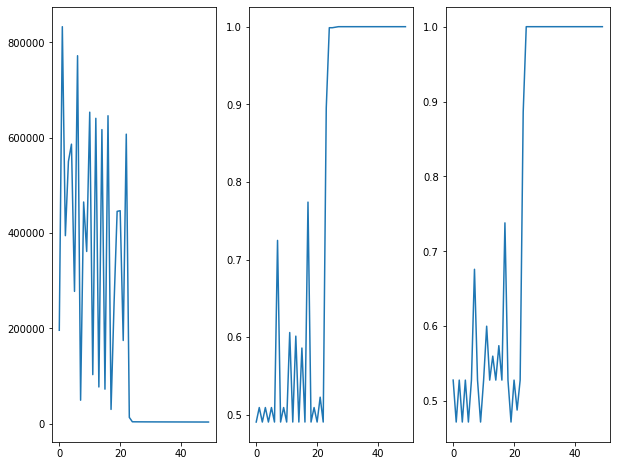

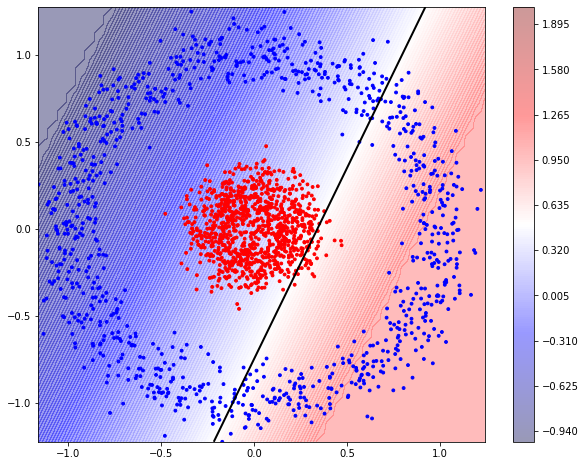

Test Accuracy: 1.0	Train Accuracy: 1.0	 Loss: 28.63484357869218


In [113]:
sim_poly = partial(kernel, d=2)

# TODO: Fit polynomial SVM 
w, b, stats = fit_svm(X_train, X_test, Y_train, Y_test, sim_poly, lr=1e-5)

# TODO: Plot accuracy and loss
fig, axs = plt.subplots(ncols=3)
print(theta)
axs[0].plot(stats["loss"])
axs[1].plot(stats["accs"]["train"])
axs[2].plot(stats["accs"]["test"])
plt.show()

# TODO: Plot decision boundary
get_probs_partial = partial(get_probs_svm, X_train=X_train, w=w, b=b, sim=sim)
plot_dec_boundary(X, Y, get_probs_partial)
plt.show()

test_acc = stats['accs']['test'][-1]
train_acc = stats['accs']['train'][-1]
print(f'Test Accuracy: {test_acc}\tTrain Accuracy: {train_acc}\t Loss: {losses[-1]}')

### Task 11 (4  Bonus Points)

Compare your results with the [Scikit learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [76]:
# TODO: Use sklearn to fit svm on traindata
from sklearn import svm


def get_probs_sklearn(X):
    # TODO: calculate value of decision function (use class method)
    
    # TODO: Set all array values greater than 1 to 1 and all values smaller than -1 to -1
    


# TODO: Plot decision boundary, calculate test and train accuracy


print(f'Test Accuracy: {test_acc}\tTrain Accuracy: {train_acc}')

IndentationError: expected an indented block (422603786.py, line 15)